# Modello convolutivo avanzato

In questo notebook implementeremo un'architettura affermata nell'ambito del riconoscimento vocale, la **VggVox**.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.fftpack as scipy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
# per il modello con estensione .onnx
import onnxruntime as rt
import tf2onnx
import onnx

## Importazione funzioni
In aggiunta alla classe per la conversione del dataset, ci serviremo delle seguenti funzioni:
- `convert_history_to_csv` - salva l'history dell'addestramento in un csv
- `convert_model_to_onnx` - converte il miglior modello **.keras** in **.onnx**
- `create_train_val_plot` - visualizza l'andamento dell'accuratezza e della perdita durante l'addestramento
- `evaluate_onnx_model` - valuta il modello sui dati di test con il modello **.onnx**
- `create_distribution_plot` - visualizza la distribuzione di accuratezza delle classi su un'immagine casuale

Anch'esse sono già state viste, perciò non ci soffermeremo troppo su di esse.

In [2]:
def convert_history_to_csv(model_history):
    # converto la history del dataframe in un dataframe pandas
    model_history_df = pd.DataFrame(model_history.history)
    # cambio il nome dell'indice e lo imposto a partire da 1
    model_history_df.index = range(1, len(model_history_df) + 1)
    model_history_df.index.name = "epochs"

    return model_history_df

def convert_model_to_onnx(model_path, input_shape):
    model = tf.keras.models.load_model(model_path)

    onnx_path = model_path.split(".")[:-1] + ["onnx"]
    onnx_path = ".".join(onnx_path)

    input_signature = [tf.TensorSpec((None, *input_shape), tf.float32, name="input")]
    onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature)

    onnx.save(onnx_model, onnx_path)

def create_train_val_plot(history, overfit=True):
    # definisco numero epoche
    epochs = range(1, len(history['accuracy']) + 1)

    # Accuracy
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    fig_acc, ax_acc = plt.subplots()

    # linea di base
    ax_acc.plot(epochs, [0.5 for x in range(len(epochs))], color="lightgray", linestyle="--", label="Base")
    # linee di accuratezza
    ax_acc.plot(epochs, accuracy, color="slategray", label="Accuratezza in addestramento")
    ax_acc.plot(epochs, val_accuracy, color="indianred", label="Accuratezza in validazione")
    # miglior accuratezza validazione
    ax_acc.axhline(y=max(val_accuracy), c='indianred', alpha=0.7, linestyle='--')
    ax_acc.text(len(epochs) * 1.07, max(val_accuracy), round(max(val_accuracy), 2), fontsize=9, fontweight="bold", horizontalalignment="left", verticalalignment="center")
    # nasconde i limiti del plot
    ax_acc.spines["right"].set_visible(False)
    ax_acc.spines["top"].set_visible(False)
    ax_acc.spines["left"].set_visible(False)
    # definizione label e titolo + legenda
    ax_acc.set_title("Accuratezza in addestramento e validazione")
    ax_acc.set_xlabel("Epoche")
    ax_acc.set_ylabel("Accuratezza (%)")
    ax_acc.legend()

    # Loss
    loss = history['loss']
    val_loss = history['val_loss']

    fig_loss, ax_loss = plt.subplots()

    # linee di loss
    ax_loss.plot(epochs, loss, color="slategray", label="Perdita in addestramento")
    ax_loss.plot(epochs, val_loss, color="indianred", label="Perdita in validazione")
    # miglior loss validazione
    ax_loss.axhline(y=min(val_loss), c='indianred', alpha=0.7, linestyle='--')
    ax_loss.text(len(epochs) * 1.07, min(val_loss), round(min(val_loss), 2), fontsize=9, fontweight="bold", horizontalalignment="left", verticalalignment="center")
    # nasconde i limiti del plot
    ax_loss.spines["right"].set_visible(False)
    ax_loss.spines["top"].set_visible(False)
    ax_loss.spines["left"].set_visible(False)
    # definizione label e titolo + legenda
    ax_loss.set_title("Perdita in addestramento e validazione")
    ax_loss.set_xlabel("Epoche")
    ax_loss.set_ylabel("Perdita")

    handles, _ = ax_loss.get_legend_handles_labels()

    if overfit:
        # area overfit
        rect = mpatches.Rectangle((np.argmin(val_loss) + 1, 0), width=100 - np.argmin(val_loss), height=max(max(loss), max(val_loss)), color='lightcoral', alpha=0.3)
        ax_loss.add_patch(rect)
        # patch overfit per legenda
        overfit = mpatches.Patch(color='indianred', alpha=0.3, label='Area overfit')
        handles, _ = ax_loss.get_legend_handles_labels()
        handles.append(overfit)

    # legenda
    ax_loss.legend(handles=handles)

    plt.show()

def evaluate_onnx_model(path_model_onnx, test_ds):
    # il fatto che sia suddiviso in batch crea dei problemi, perciò vengono rimossi
    test_ds = test_ds.unbatch()

    # carica il modello utilizzando il file onnx
    m = rt.InferenceSession(path_model_onnx)

    # trasforma il dataset in array numpy
    spectrogram_np = np.array([spectrogram.numpy() for spectrogram, _ in test_ds], dtype=np.float32)
    labels_np = np.array([label.numpy() for _, label in test_ds])

    # esegue le predizione del modello
    pred_onnx = m.run(None, {'input': spectrogram_np})
    # ottiene la predizione corretta
    predictions = np.argmax(pred_onnx[0], axis=1)
    # computa la accuratezza
    accuracy = np.mean(predictions == labels_np)
    # stampa l'accuratezza
    print(f"Accuratezza: {accuracy:.3f}")

def create_distribution_plot(model, audio, label):
    prediction = model(audio) # ottiene la predizione del modello sull'audio preso in input

    random_audio_index = np.random.randint(0, len(prediction) - 1) # abbiamo notato che mostravamo sempre la classe 'no', in questo modo cambiano le classi che vengono mostrate

    softmax_pred = tf.nn.softmax(prediction[random_audio_index]) # applichiamo nuovamente la softmax in modo tale da avere dei dati leggibili
    pred_label = np.argmax(softmax_pred) # salva l'indice della label predetta dal nostro modello, quella con la probabilità più alta

    colors = ['indianred'] * len(audio_label_names) # crea un vettore di lunghezza 30 (la quantità delle nostre label) di colore rosso

    if pred_label == label[random_audio_index].numpy(): # se la label che viene predetta è corretta, quest'ultima viene colorata di verde
        colors[pred_label] = 'seagreen'
    else: # se la label predetta è sbagliata, allora viene colorata di verde la corretta e di gialla la predetta
        colors[pred_label] = 'khaki'
        colors[label[random_audio_index].numpy()] = 'seagreen'

    plt.figure(figsize=(12, 4))

    plt.bar(audio_label_names, softmax_pred.numpy(), color=colors)
    plt.xticks(rotation=45)

    # vengono dichiarati i colori della legenda
    other_values_patch = mpatches.Patch(color='indianred', label='Altre classi')
    pred_value_patch = mpatches.Patch(color='khaki', label='Classe predetta')
    correct_value_patch = mpatches.Patch(color='green', label='Classe corretta')

    # disegna la legenda con i colori necessari
    if pred_label == label[random_audio_index].numpy(): # se la label viene predetta correttamente, non è necessario mostrare il colore giallo (non viene rapprresentato nel plot)
        plt.legend(handles=[other_values_patch, correct_value_patch])
    else:
        plt.legend(handles=[other_values_patch, pred_value_patch, correct_value_patch])

    plt.show()

Funzione per mostrare la distribuzione di accuratezza delle classi.

Funzioni per la conversione del dataset in spettrogrammi, filterbanks, e mfcc.

In [3]:
class DatasetConverter:
    def __init__(self, dataset):
        self.dataset = dataset

    def convert(self, option):
        available_options = ['spectrogram', 'filterbanks', 'mfcc']

        if option == available_options[0]: # 'spectrogram'
            return self.get_spectrogram_dataset()
        elif option == available_options[1]: # 'filterbanks'
            return self.get_filterbanks_dataset()
        elif option == available_options[2]: # 'mfcc'
            return self.get_mfcc_dataset()
        else:
            raise ValueError(f"Opzione non disponibile: inserire una delle seguenti opzioni: {available_options}")

    # INIZIO SPETTROGRAMMI
    def squeeze(self, audio, labels):
        audio = tf.squeeze(audio, axis=-1)
        return audio, labels

    def get_spectrogram(self, waveform):
    # Applichiamo la short-time Fourier transorm
        spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
        spectrogram = tf.abs(spectrogram)

        return spectrogram[..., tf.newaxis]

    def get_spectrogram_dataset(self):
        # Squeeze
        self.dataset = self.dataset.map(self.squeeze, tf.data.AUTOTUNE)
        self.dataset = self.dataset.map(lambda x, y: (self.get_spectrogram(x), y), num_parallel_calls=tf.data.AUTOTUNE)

        return self.dataset

    # FINE SPETTROGRAMMI

    def convert_to_numpy(self, dataset):
        audio_data = []
        labels = []

        dataset = dataset.unbatch()

        for audio, label in dataset:
            audio_data.append(audio.numpy())  # Assumendo che l'audio sia un tensore, converti in array numpy
            labels.append(label.numpy())      # Assumendo che la classe sia un tensore, converti in array numpy

        audio_data = np.array(audio_data)
        labels = np.array(labels)

        return audio_data, labels

    # INIZIO FILTERBANKS
    # Finestra di Hamming
    def makeHamming(self, M):
        R = (( M - 1 ) / 2 , M / 2)[M % 2 == 0]
        w = (np.hamming(M), np.hamming(M + 1))[M % 2 == 0]
        if M % 2 != 0:
            w[0] = w[0]/2
            w[M-1] = w[M-1]/2
        else:
            w = w[:M]

        return w

    # Funzione che converte gli Heartz in Mel
    def hztomel(self, hz):
        return (2595 * np.log10(1 + hz / 700))

    # Funzione che converte i Mel in Heartz
    def meltohz(self, mel):
        return (700 * (10**(mel / 2595) - 1))

    def compute_filterbanks(self, audios_np, pre_emphasis=0.97, sample_rate=16000, frame_size=0.025, frame_stride=0.01, NFFT=512, nfilt=40):
        filterbanks_np = []

        for samples in audios_np:
            emphasized_audio = np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1]) # Il filtro di pre-enfasi si utilizza per amplificare le alte frequenze
            audio_length = len(emphasized_audio)

            frame_length, frame_step = int(frame_size * sample_rate), int(frame_stride * sample_rate)

            num_frames = int(np.ceil(float(np.abs(audio_length - frame_length)) / frame_step))

            pad_audio_length = num_frames * frame_step + frame_length
            z = np.zeros((pad_audio_length - audio_length))
            pad_audio = np.append(emphasized_audio, z)

            indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
            frames = pad_audio[indices.astype(np.int32, copy=False)]

            # Usiamo la funzione di Hamming
            hamming_window = self.makeHamming(frame_length)

            mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitudo della FFT
            pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

            # convertiamo hz in mel
            low_freq_mel = self.hztomel(0)
            high_freq_mel = self.hztomel(sample_rate / 2)

            mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
            hz_points = self.meltohz(mel_points)

            bin = np.floor((NFFT + 1) * hz_points / sample_rate)

            fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))

            for m in range(1, nfilt + 1):
                f_m_minus = int(bin[m - 1])
                f_m = int(bin[m])
                f_m_plus = int(bin[m + 1])

                for k in range(f_m_minus, f_m):
                    fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
                for k in range(f_m, f_m_plus):
                    fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

            # in questo momento invece calcoliamo i filter banks per i segmenti di audio, utilizzando i filtri triangolari appena creati
            filter_banks = np.dot(pow_frames, fbank.T)
            filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
            filter_banks = 20 * np.log10(filter_banks)

            filterbanks_np.append(filter_banks)

        return np.array(filterbanks_np)

    def get_filterbanks_dataset(self):
        audios, labels = self.convert_to_numpy(self.dataset)

        filterbanks = self.compute_filterbanks(audios)
        filterbanks = np.expand_dims(filterbanks, axis=-1)

        self.dataset = tf.data.Dataset.from_tensor_slices((filterbanks, labels))
        self.dataset = self.dataset.batch(32)

        return self.dataset
    # FINE FILTERBANKS

    # INIZIO MFCC
    def compute_mfcc(self, filter_banks, num_ceps=12, cep_lifter=22):
        mfcc_np = []

        for f in filter_banks:
            mfcc = scipy.dct(f, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Viene applicata la DCT ai filterbanks, in modo da renderli meno correlati

            (nframes, ncoeff) = mfcc.shape
            n = np.arange(ncoeff)

            lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter) # Il lifter viene utilizzato per precauzione, in quanto migliora il riconoscimento del parlato
            mfcc *= lift

            mfcc_np.append(mfcc)

        return np.array(mfcc_np)


    def get_mfcc_dataset(self):
        audios, labels = self.convert_to_numpy(self.dataset)

        filterbanks = self.compute_filterbanks(audios)
        mfcc = self.compute_mfcc(filterbanks)

        mfcc = np.expand_dims(mfcc, axis=-1)

        self.dataset = tf.data.Dataset.from_tensor_slices((mfcc, labels))
        self.dataset = self.dataset.batch(32)

        return self.dataset

    # FINE MFCC

Creiamo il train set e il validation set, inoltre mostriamo le classi del dataset di rumori, che andremo ad utilizzare in seguito per il processo di data agumentation.

In [4]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory ='../reduced_dataset/dataset/audio',
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True,
    subset='both', # necessario se stiamo utilizzando validation_split
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split
)
audio_label_names = train_ds.class_names

noise_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../noise_dataset',
    batch_size = 1
)

noise_label_names = noise_ds.class_names

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.
Found 14 files belonging to 14 classes.


## Applicazione tecniche data augmentation
Abbiamo già visto l'utilizzo delle tecniche che andremo a applicare in questo momento, perciò non ci soffermeremo sulla loro spiegazione, ma ne descriveremo i passaggi in modo sinteitco.

Tagliamo gli audio del dataset rumoroso.

In [5]:
def cut_audios(dataset, length):
    new_audios = [] # Inizializziamo una lista dove inseriremo i nostri audio tagliati
    labels = []

    # Iteriamo nel dataset
    for audio, label in dataset:
        # Tagliamo l'audio ad un secondo e lo appendiamo a una lista
        labels.append(label.numpy())

        audio = tf.reshape(audio, [-1])[np.shape(audio)[1]//2:np.shape(audio)[1]//2 + length]
        new_audios.append(audio.numpy()) # Convertiamo in array per poterli modificare

    return new_audios, labels

cut_noise_audios, cut_noise_labels = cut_audios(noise_ds, 16000)

Creiamo il nuovo dataset, unendo l'originale con quello rumoroso. L'output che otteneremo è una lista.

In [6]:
def mix_audios(original_audios, noise_audios):
    mixed_dataset = [] # Inizializziamo la lista dove inseriremo gli audio del dataset principale uniti agli audio del dataset di rumori

    original_audios = original_audios.unbatch() # Il nostro training set ha una batch_size di 32, per rendere il processo più semplice unbatchiamo

    # Per ogni audio del dataset originale
    for audio, label in original_audios:
        audio = np.squeeze(audio, axis=-1) # Rimuoviamo l'ultimo asse inutile (quella dei canali)

        # Scegliamo in modo randomico un audio dalla lista degli audio rumorosi
        noise_sample = random.choice(noise_audios)

        # Calcoliamo l'ampiezza massima dell'audio rumoroso
        max_amplitude_audio = np.max(np.abs(audio))
        max_amplitude_noise = np.max(np.abs(noise_sample))
        # Calcoliamo un noise factor che varia a seconda dell'ampiezza massima di entrambi gli audio
        noise_factor = max_amplitude_audio / max_amplitude_noise
        noise_factor = min(noise_factor, 1.0)

        noise_sample = noise_sample * noise_factor

        mixed_audio = audio + noise_sample # Uniamo l'audio original al rumore

        # Aggiungiamo l'audio con noise alla lista
        mixed_dataset.append((mixed_audio, label))

    return mixed_dataset

mixed_train_list = mix_audios(train_ds, cut_noise_audios)
mixed_val_list = mix_audios(validation_ds, cut_noise_audios)

Convertiamo la lista in un dataset di tensori.

In [7]:
def create_mixed_ds(dataset_list):
    audio_data = [tf.convert_to_tensor(audio, dtype=tf.float32) for audio, label in dataset_list]
    labels = [label for _, label in dataset_list]

    audio_data = tf.expand_dims(audio_data, axis=-1)

    mixed_train_ds = tf.data.Dataset.from_tensor_slices((audio_data, labels))
    mixed_train_ds = mixed_train_ds.batch(32)
    return mixed_train_ds

mixed_train_ds = create_mixed_ds(mixed_train_list)
mixed_validation_ds = create_mixed_ds(mixed_val_list)

## VoxProfunda (Spettrogrammi)
La **VoxProfunda** è un'architettura basata sulla **VggVox** che a sua volta è fondata sulla **ResNet-34**.

In [8]:
spect_mixed_train_ds = DatasetConverter(mixed_train_ds)
spect_mixed_train_ds = spect_mixed_train_ds.convert('spectrogram')

spect_mixed_validation_ds = DatasetConverter(mixed_validation_ds)
spect_mixed_validation_ds = spect_mixed_validation_ds.convert('spectrogram')

spect_mixed_val_ds = spect_mixed_validation_ds.take(spect_mixed_validation_ds.cardinality() // 2)
spect_mixed_test_ds = spect_mixed_validation_ds.skip(spect_mixed_validation_ds.cardinality() // 2)

### ResNet-34 e VggVox
La **ResNet** è un'architettura di reti neurali convolutivi composta da 34 livelli. La sua peculiarità s'incentra sull'utilizzo dei blocchi residuali. Quest'ultimi, come abbiamo già imputato, prevengono il problema del **gradiente evanescente**.

Questa architettura, e le sue simili, sono ampiamente utilizzate nell'ambito della **computer vision**.

Dalla modifica della **ResNet-34 e Resnet-50**, le quali differiscono per il numero di livelli e filtri, nasce la **VggVox**. Questa architettura è specializzata nei compiti di elaborazione del parlato. La modifica effettuata consiste nella sostituzione dell'ultimo livello denso con due livelli:
- un livello densamente connesso 9x1
- un livello di average pooling 1xN, dove N dipende dalla lunghezza del segmento audio

Adattando la VggVox al nostro task (30 classi di output), abbiamo creato la VoxProfunda.

In [9]:
class VoxProfunda():
    def __init__(self):
        self.counter = 0

    def conv2D_x(self, filters, kernel_size, conv_n_layers, repeat, strides=1, padding="valid", name=False): # Per implementare diversi livelli convoluzionali
        self.counter += 1

        if name == False:
            if self.counter == repeat:
                name = "conv" + str(self.counter)
            else:
                name = "conv" + str(self.counter) + "_" + str(repeat)

        conv2D =  tf.keras.Sequential(name=name)

        for repetition in range(repeat):
            for layer in range(conv_n_layers):
                conv2D.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding))
            conv2D.add(tf.keras.layers.BatchNormalization())
            conv2D.add(tf.keras.layers.Activation("relu"))

        return conv2D

    def residual_block(self, x, filters, kernel_size, conv_n_layers, repeat, strides=1, padding="valid", name=False, pooling=False): # Blocchi residui, una delle caratteristiche della ResNet, in modo da evitare il problema dei gradienti evanescenti
        residual = x
        x = self.conv2D_x(filters, kernel_size, conv_n_layers, repeat, strides, padding, name)(x)
        if pooling:
            x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding="same")(x)
            residual = tf.keras.layers.Conv2D(filters, 1, strides=4)(residual)
        elif filters != residual.shape[-1]:
            residual = tf.keras.layers.Conv2D(filters, 1)(residual)

        output_layer = tf.keras.layers.add([x, residual])
        return output_layer

    def get_model(self, input_shape):
        inputs = tf.keras.Input(shape=input_shape, name="input")
        normalization = tf.keras.layers.Normalization(name="normalization")(inputs)

        # Blocco di apprendimento delle caratteristiche
        # conv1
        conv1 = self.residual_block(normalization,filters=64, kernel_size=(7,7), conv_n_layers=1, repeat=1, strides=2, padding="same", pooling=True)

        # conv2_x * 3
        conv2_3 = self.residual_block(conv1, filters=64, kernel_size=(3,3), conv_n_layers=2, repeat=3, padding="same")

        # conv3_x * 4
        conv3_4 = self.residual_block(conv2_3, filters=128, kernel_size=(3,3), conv_n_layers=2, repeat=4, padding="same")

        # conv4_x * 6
        conv4_6 = self.residual_block(conv3_4, filters=256, kernel_size=(3,3), conv_n_layers=2, repeat=6, padding="same")

        # conv4_x * 3
        conv5_3 = self.residual_block(conv4_6, filters=512, kernel_size=(3,3), conv_n_layers=2, repeat=3, padding="same")

        # global average pooling
        fc1 = tf.keras.layers.Conv2D(filters=512, kernel_size=(9, 1), strides=1, activation="relu", name="fc1")(conv5_3)

        # pool_time
        avg_pooling = tf.keras.layers.GlobalAveragePooling2D(name="pool_time")(fc1)

        #dropout 1
        dropout_1 = tf.keras.layers.Dropout(0.5, name="dropout_1")(avg_pooling)

        # softmax
        outputs = tf.keras.layers.Dense(30, activation="softmax", name="softmax")(dropout_1)

        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [10]:
voxprofunda = VoxProfunda()

for audio, label in spect_mixed_train_ds:
    voxprofunda = voxprofunda.get_model(audio.shape[1:])
    break

voxprofunda.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

voxprofunda.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 124, 129, 1)]        0         []                            
                                                                                                  
 normalization (Normalizati  (None, 124, 129, 1)          3         ['input[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1 (Sequential)          (None, 62, 65, 64)           3456      ['normalization[0][0]']       
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 31, 33, 64)           0         ['conv1[0][0]']           

Il modello ha un totale di  **23.6 milioni di parametri**, una differenza notevole rispetto al nostro modello di base iniziale il quale ne aveva meno di **1.5 milioni**.

In [11]:
callback_voxprofunda = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/resnet/voxprofunda_spect.keras", save_best_only=True, monitor="val_loss")]
history_voxprofunda = voxprofunda.fit(spect_mixed_train_ds, epochs=100, validation_data=spect_mixed_val_ds, callbacks=callback_voxprofunda)

Epoch 1/100
243/243 [==============================] - 49s 102ms/step - loss: 3.4276 - accuracy: 0.0532 - val_loss: 8.8679 - val_accuracy: 0.0297
Epoch 2/100
243/243 [==============================] - 20s 82ms/step - loss: 3.1962 - accuracy: 0.0867 - val_loss: 5.2905 - val_accuracy: 0.0382
Epoch 3/100
243/243 [==============================] - 20s 82ms/step - loss: 2.7875 - accuracy: 0.1862 - val_loss: 2.7544 - val_accuracy: 0.2419
Epoch 4/100
243/243 [==============================] - 20s 82ms/step - loss: 2.1867 - accuracy: 0.3469 - val_loss: 2.0956 - val_accuracy: 0.3792
Epoch 5/100
243/243 [==============================] - 20s 82ms/step - loss: 1.6976 - accuracy: 0.4946 - val_loss: 1.6946 - val_accuracy: 0.5093
Epoch 6/100
243/243 [==============================] - 20s 82ms/step - loss: 1.3707 - accuracy: 0.5773 - val_loss: 1.3414 - val_accuracy: 0.5992
Epoch 7/100
243/243 [==============================] - 20s 82ms/step - loss: 1.1692 - accuracy: 0.6518 - val_loss: 1.1787 - val_a

Essendo un modello molto pesante, salviamo i dati della cronologia del modello in un file csv, e convertiamo il miglior modello nell'estensione **.onnx**.

In [12]:
voxprofunda_df = convert_history_to_csv(history_voxprofunda)
voxprofunda_df.to_csv("model_histories/noise/resnet/voxprofunda_spect.csv")

convert_model_to_onnx("bestmodels/noise/resnet/voxprofunda_spect.keras", (124, 129, 1))

Analizziamo l'andamento dell'accuratezza e della perdita durante l'addestramento.

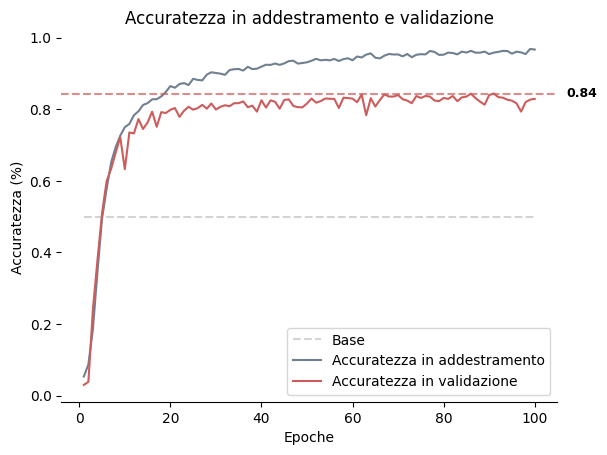

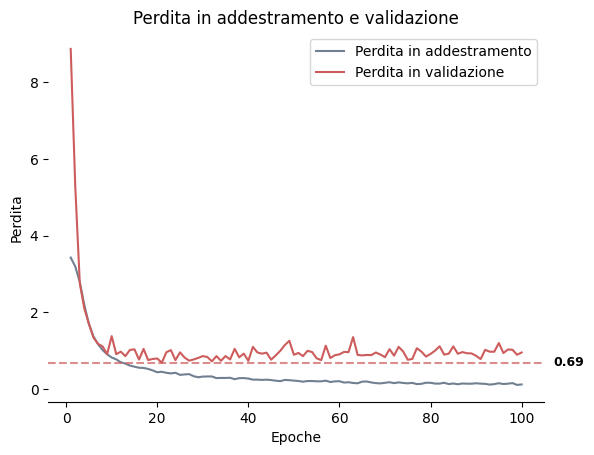

In [13]:
create_train_val_plot(history_voxprofunda.history, overfit=False)

Dal grafico notiamo che il modello NON entra in overfitting, e raggiunge degli ottimi risultati fin da subito. La perdita ottenuta nella validazione è bassa, e l'accuratezza in fase di validazione è anch'essa la migliore mai ottenuta.

Ovviamente tutte queste considerazioni sono valide nell'argomento generale della data augmentation.

In [14]:
best_voxprofunda = tf.keras.models.load_model("bestmodels/noise/resnet/voxprofunda_spect.keras")
test_loss, test_acc = best_voxprofunda.evaluate(spect_mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 5s 42ms/step - loss: 0.6769 - accuracy: 0.8105
Accuratezza: 0.811


In [15]:
evaluate_onnx_model("bestmodels/noise/resnet/voxprofunda_spect.onnx", spect_mixed_test_ds)

Accuratezza: 0.811


Abbiamo ottenuto un'accuratezza del **81%**! Ben 10 punti percentuali in più rispetto al nostro modello migliore (il convolutivo base con Fine Tuning, che ha ottenuto un'accuratezza del 71%).
Il modello ha impiegato circa 30 minuti ad addestrare con la GPU A100 con Ram Avanzata.

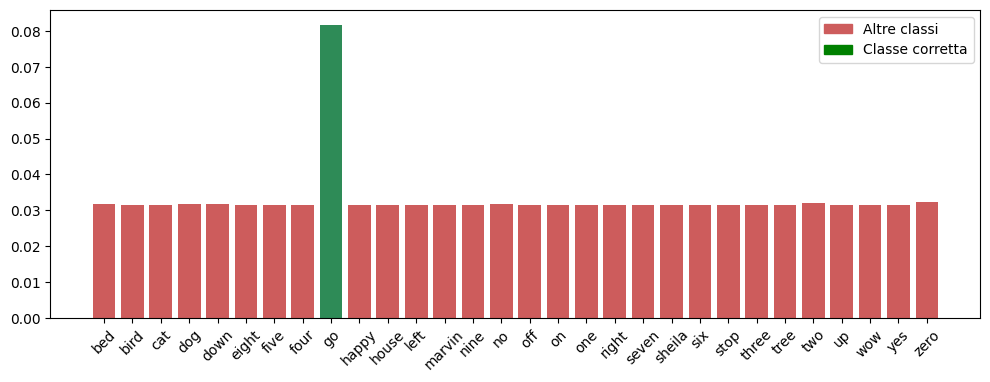

In [16]:
for audio, label in spect_mixed_test_ds: # prendiamo un audio a caso del test e creiamo la distribuzione
    create_distribution_plot(best_voxprofunda, audio, label)
    break

## Addestramento VoxProfunda (Filterbanks)
Procediamo ad addestrare lo stesso modello sui filterbanks. Non ripeteremo alcuna spiegazione essendo un passaggio ormai noto.

In [17]:
fb_mixed_train_ds = DatasetConverter(mixed_train_ds)
fb_mixed_train_ds = fb_mixed_train_ds.convert('filterbanks')

fb_mixed_validation_ds = DatasetConverter(mixed_validation_ds)
fb_mixed_validation_ds = fb_mixed_validation_ds.convert('filterbanks')

fb_mixed_val_ds = fb_mixed_validation_ds.take(fb_mixed_validation_ds.cardinality() // 2)
fb_mixed_test_ds = fb_mixed_validation_ds.skip(fb_mixed_validation_ds.cardinality() // 2)

In [18]:
del voxprofunda # Eliminiamo il modello precedente, non è obbligatorio farlo, ma è una buona pratica

voxprofunda = VoxProfunda()

for audio, label in fb_mixed_train_ds:
    voxprofunda = voxprofunda.get_model(audio.shape[1:])
    break

voxprofunda.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

voxprofunda.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 98, 40, 1)]          0         []                            
                                                                                                  
 normalization (Normalizati  (None, 98, 40, 1)            3         ['input[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1 (Sequential)          (None, 49, 20, 64)           3456      ['normalization[0][0]']       
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 25, 10, 64)           0         ['conv1[0][0]']         

In [19]:
callback_voxprofunda = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/resnet/voxprofunda_fb.keras", save_best_only=True, monitor="val_loss")]
history_voxprofunda = voxprofunda.fit(fb_mixed_train_ds, epochs=100, validation_data=fb_mixed_val_ds, callbacks=callback_voxprofunda)

Epoch 1/100
243/243 [==============================] - 28s 46ms/step - loss: 4.7340 - accuracy: 0.0372 - val_loss: 3.3988 - val_accuracy: 0.0266
Epoch 2/100
243/243 [==============================] - 9s 37ms/step - loss: 3.3993 - accuracy: 0.0389 - val_loss: 3.3962 - val_accuracy: 0.0320
Epoch 3/100
243/243 [==============================] - 9s 37ms/step - loss: 3.3888 - accuracy: 0.0469 - val_loss: 3.3921 - val_accuracy: 0.0382
Epoch 4/100
243/243 [==============================] - 9s 37ms/step - loss: 3.3694 - accuracy: 0.0585 - val_loss: 3.3506 - val_accuracy: 0.0475
Epoch 5/100
243/243 [==============================] - 7s 30ms/step - loss: 3.2843 - accuracy: 0.0695 - val_loss: 3.8986 - val_accuracy: 0.0355
Epoch 6/100
243/243 [==============================] - 9s 37ms/step - loss: 3.2073 - accuracy: 0.0874 - val_loss: 3.0821 - val_accuracy: 0.1227
Epoch 7/100
243/243 [==============================] - 7s 30ms/step - loss: 3.0844 - accuracy: 0.1207 - val_loss: 8.3680 - val_accuracy

In [20]:
voxprofunda_df = convert_history_to_csv(history_voxprofunda)
voxprofunda_df.to_csv("model_histories/noise/resnet/voxprofunda_fb.csv")

convert_model_to_onnx("bestmodels/noise/resnet/voxprofunda_fb.keras", (98, 40, 1))

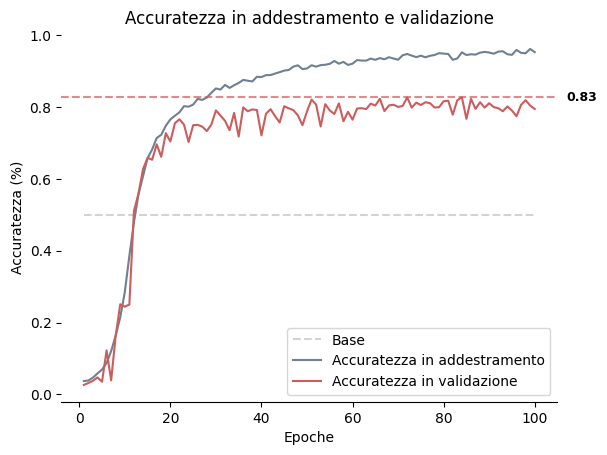

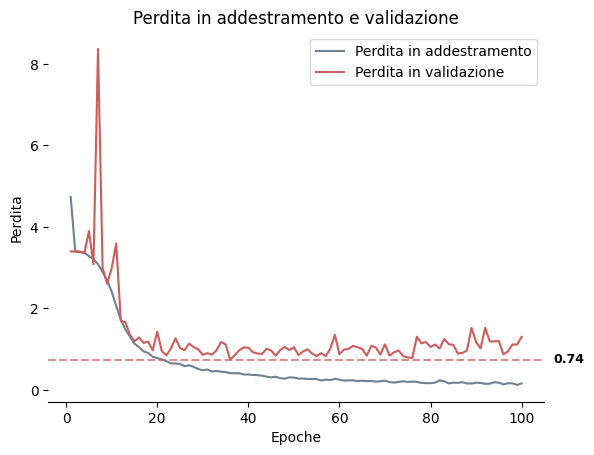

In [21]:
create_train_val_plot(history_voxprofunda.history, overfit=False)

Dal grafico notiamo che il modello NON entra in overfitting, e raggiunge dei buoni risultati. È interessante notare il picco che si ha all'inizio della perdita nella validazione. Per quanto riguarda l'accuratezza, notiamo dei buoni risultati sia in fase di validazione che di addestramento.

In [22]:
best_voxprofunda = tf.keras.models.load_model("bestmodels/noise/resnet/voxprofunda_fb.keras")
test_loss, test_acc = best_voxprofunda.evaluate(fb_mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 2s 17ms/step - loss: 0.7525 - accuracy: 0.7912
Accuratezza: 0.791


In [23]:
evaluate_onnx_model("bestmodels/noise/resnet/voxprofunda_fb.onnx", fb_mixed_test_ds)

Accuratezza: 0.792


L'accuratezza pari al 79% è finora la più alta ottenuta nell'addestramento con i filter banks degli audio rumorosi, infatti il risultato migliore ottenuto con i filter banks degli audio rumorosi, utilizzando il modello convolutivo di base abbiamo ottenuto il 73% di accuratezza.

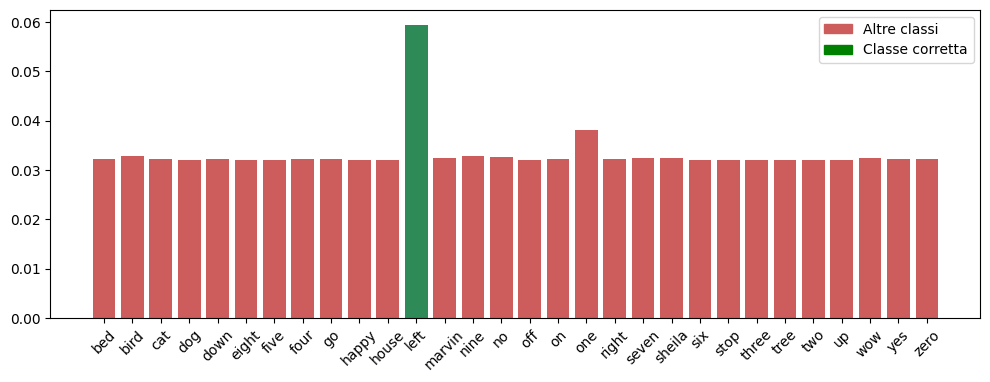

In [24]:
for audio, label in fb_mixed_test_ds: # prendiamo un audio a caso del test e creiamo la distribuzione
    create_distribution_plot(best_voxprofunda, audio, label)
    break

## Addestramento VoxProfunda (MFCC)
Infine ripetiamo il procedimento per gli MFCC

In [25]:
mfcc_mixed_train_ds = DatasetConverter(mixed_train_ds)
mfcc_mixed_train_ds = mfcc_mixed_train_ds.convert('mfcc')

mfcc_mixed_validation_ds = DatasetConverter(mixed_validation_ds)
mfcc_mixed_validation_ds = mfcc_mixed_validation_ds.convert('mfcc')

mfcc_mixed_val_ds = mfcc_mixed_validation_ds.take(mfcc_mixed_validation_ds.cardinality() // 2)
mfcc_mixed_test_ds = mfcc_mixed_validation_ds.skip(mfcc_mixed_validation_ds.cardinality() // 2)

In [26]:
del voxprofunda

voxprofunda = VoxProfunda()

for audio, label in mfcc_mixed_train_ds:
    voxprofunda = voxprofunda.get_model(audio.shape[1:])
    break

voxprofunda.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

voxprofunda.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 98, 12, 1)]          0         []                            
                                                                                                  
 normalization (Normalizati  (None, 98, 12, 1)            3         ['input[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1 (Sequential)          (None, 49, 6, 64)            3456      ['normalization[0][0]']       
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 25, 3, 64)            0         ['conv1[0][0]']         

In [27]:
callback_voxprofunda = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/resnet/voxprofunda_mfcc.keras", save_best_only=True, monitor="val_loss")]
history_voxprofunda = voxprofunda.fit(mfcc_mixed_train_ds, epochs=100, validation_data=mfcc_mixed_val_ds, callbacks=callback_voxprofunda)

Epoch 1/100
243/243 [==============================] - 26s 41ms/step - loss: 4.9472 - accuracy: 0.0403 - val_loss: 3.3821 - val_accuracy: 0.0370
Epoch 2/100
243/243 [==============================] - 8s 34ms/step - loss: 3.3552 - accuracy: 0.0562 - val_loss: 3.3346 - val_accuracy: 0.0640
Epoch 3/100
243/243 [==============================] - 8s 34ms/step - loss: 3.2030 - accuracy: 0.0981 - val_loss: 2.9683 - val_accuracy: 0.1454
Epoch 4/100
243/243 [==============================] - 6s 27ms/step - loss: 2.8558 - accuracy: 0.1834 - val_loss: 4.3909 - val_accuracy: 0.1613
Epoch 5/100
243/243 [==============================] - 6s 27ms/step - loss: 2.4360 - accuracy: 0.3012 - val_loss: 3.0746 - val_accuracy: 0.2812
Epoch 6/100
243/243 [==============================] - 8s 34ms/step - loss: 2.0428 - accuracy: 0.4134 - val_loss: 1.7726 - val_accuracy: 0.4703
Epoch 7/100
243/243 [==============================] - 8s 34ms/step - loss: 1.7783 - accuracy: 0.4843 - val_loss: 1.5354 - val_accuracy

In [28]:
voxprofunda_df = convert_history_to_csv(history_voxprofunda)
voxprofunda_df.to_csv("model_histories/noise/resnet/voxprofunda_mfcc.csv")

convert_model_to_onnx("bestmodels/noise/resnet/voxprofunda_mfcc.keras", (98, 12, 1))

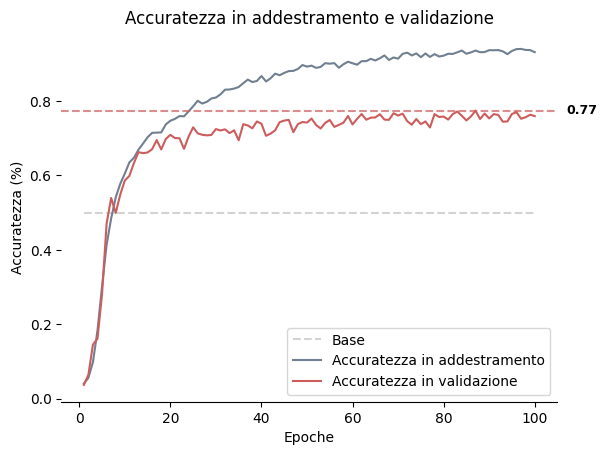

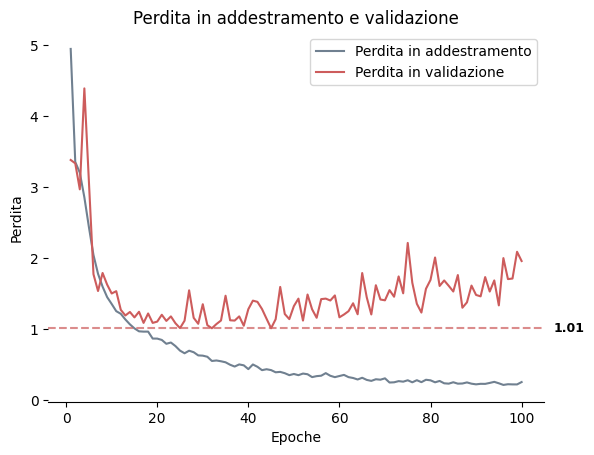

In [29]:
create_train_val_plot(history_voxprofunda.history, overfit=False)

Durante il progetto abbiamo potuto notare che i modelli presentati non erano ottimi per questo tipo di input. In questo caso VoxProfunda è ovviamente riuscito a generalizzare in modo migliore rispetto al restante dei modelli,

In [30]:
best_voxprofunda = tf.keras.models.load_model("bestmodels/noise/resnet/voxprofunda_mfcc.keras")
test_loss, test_acc = best_voxprofunda.evaluate(mfcc_mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 2s 11ms/step - loss: 1.0140 - accuracy: 0.7063
Accuratezza: 0.706


In [31]:
evaluate_onnx_model("bestmodels/noise/resnet/voxprofunda_mfcc.onnx", mfcc_mixed_test_ds)

Accuratezza: 0.706


L'accuratezza del modello è pari a **70.6%**, quasi 7 percentili in più rispetto al migliore dei modelli convolutivi base (il modello riguardante il paragrafo della risoluzione dell'overfitting).

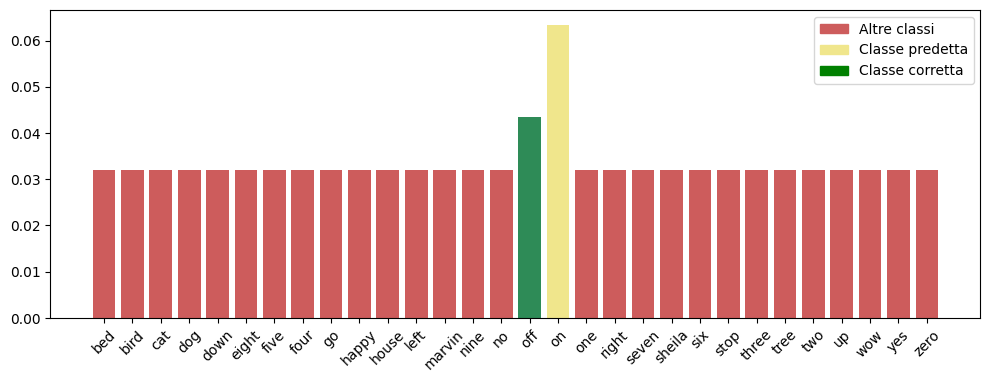

In [32]:
for audio, label in mfcc_mixed_test_ds: # prendiamo un audio a caso del test e creiamo la distribuzione
    create_distribution_plot(best_voxprofunda, audio, label)
    break